# Artificial Intelligence: Homework 2 - Machine Learning

Alexandru Sima (332CA)


In [1]:
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
import pandas as pd
import scipy as sp
import sklearn as sk

%matplotlib inline

## Air pollution


In [2]:
data = pd.read_csv("datasets/air_pollution_full.csv")

##### Split data by type


In [3]:
def split_data(
    data: pd.DataFrame,
    numeric_columns: list[str],
    categorical_columns: list[str],
    label_column: str,
) -> tuple[pd.DataFrame, pd.DataFrame, pd.Series]:
    numeric_attrs = [x for x in numeric_columns if x in data.columns]
    categorical_attrs = [x for x in categorical_columns if x in data.columns]

    numeric_attrs = data[numeric_attrs]
    categorical_attrs = data[categorical_attrs]
    labels = data[label_column]

    return numeric_attrs, categorical_attrs, labels

In [4]:
numeric_columns = [
    "AQI_Value",
    "CO_Value",
    "Ozone_Value",
    "NO2_Value",
    "PM25_Value",
    "VOCs",
    "SO2",
]
categorical_columns = [
    "Country",
    "City",
    "CO_Category",
    "Ozone_Category",
    "NO2_Category",
    "PM25_Category",
    "Emissions",
]
label_column = "AQI_Category"

In [5]:
num_data, cat_data, labels = split_data(
    data, numeric_columns, categorical_columns, label_column
)

### Exploratory data analysis


#### Numerical values


In [6]:
def show_numerical_info(data: pd.DataFrame):
    sns.boxplot(data=data, orient="h")
    display(data.describe())

,AQI_Value,CO_Value,Ozone_Value,NO2_Value,PM25_Value,VOCs,SO2
count,23463.000000,23463.000000,21117.000000,23463.000000,23463.000000,23463.000000,23463.000000
mean,72.010868,1.368367,35.239665,43.084153,68.519755,185.053110,4.447841
std,56.055220,1.832064,28.149280,196.079179,54.796443,140.486759,5.953601
min,6.000000,0.000000,0.000000,0.000000,0.000000,12.415670,-18.528019
25%,39.000000,1.000000,21.000000,0.000000,35.000000,103.267345,0.735052
50%,55.000000,1.000000,31.000000,1.000000,54.000000,142.972272,4.286825
75%,79.000000,1.000000,40.000000,4.000000,79.000000,204.227896,7.916001
max,500.000000,133.000000,222.000000,1003.063334,500.000000,1280.988229,234.692971


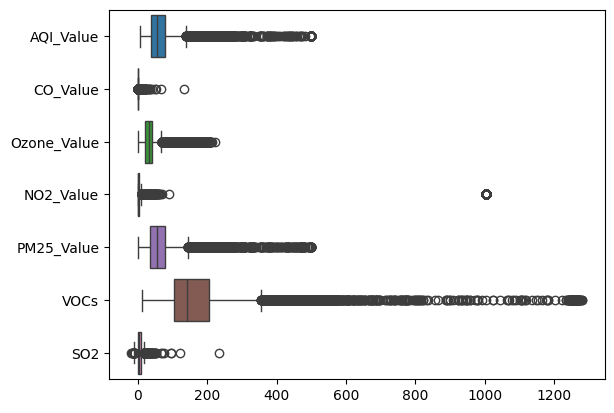

In [7]:
show_numerical_info(num_data)

#### Categorical values


In [8]:
def show_categorical_info(data: pd.DataFrame, target: pd.Series):
    sns.histplot(target)
    plt.xticks(rotation=45)
    plt.show()

    for column in data.columns:
        # Ignore unique columns
        if max(data[column].value_counts()) == 1:
            continue

        plt.figure(figsize=(10, 5))
        sns.histplot(data[column])

        if len(data[column].unique()) > 20:
            plt.xticks([])

        plt.xticks(rotation=45)
        plt.show()

    display(data.describe())

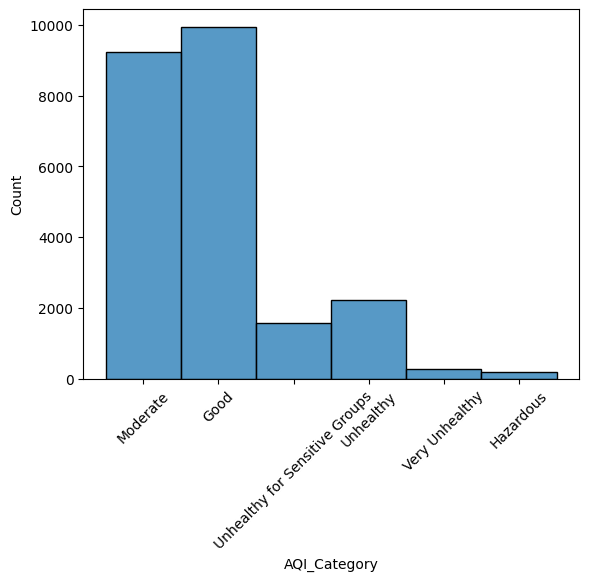

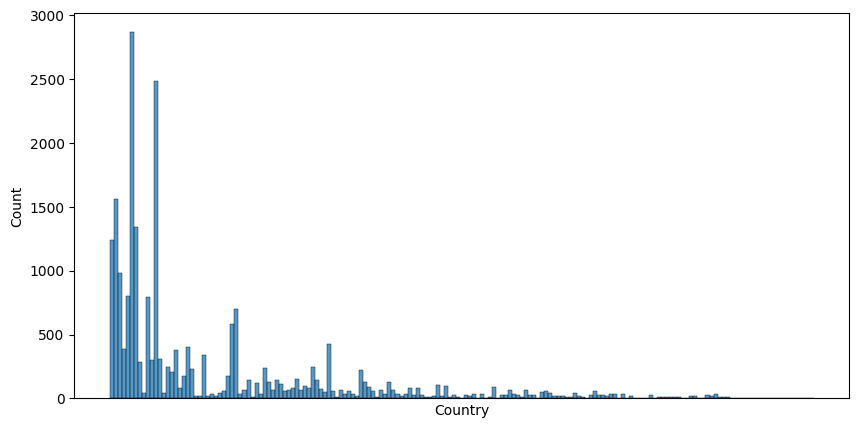

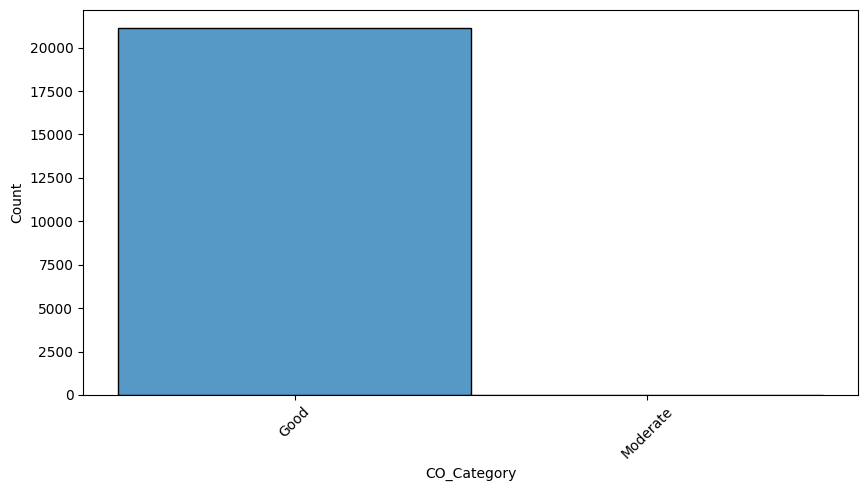

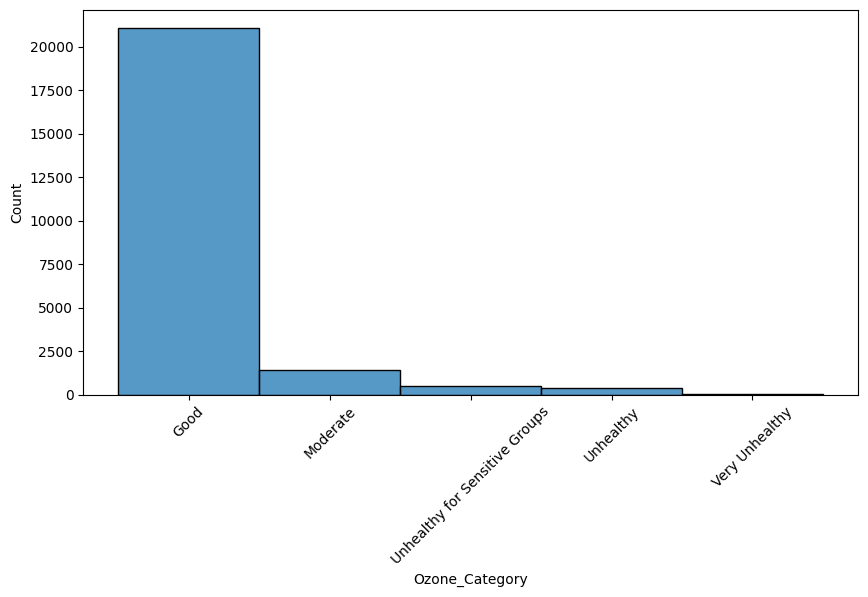

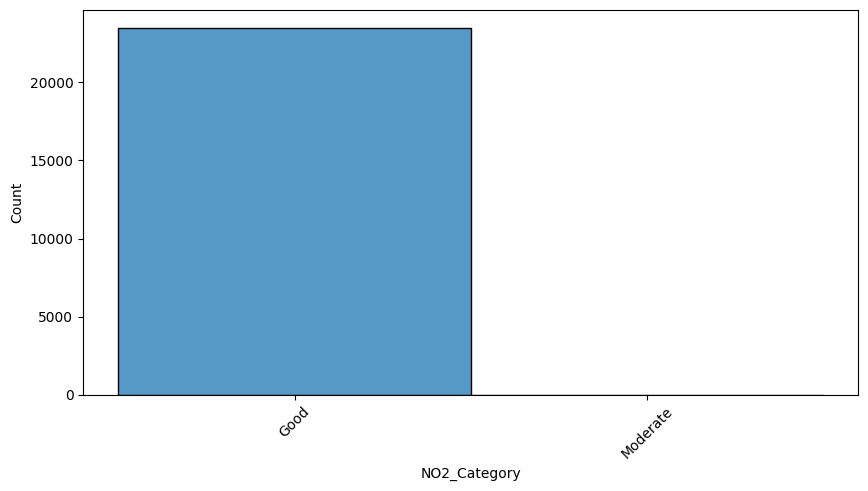

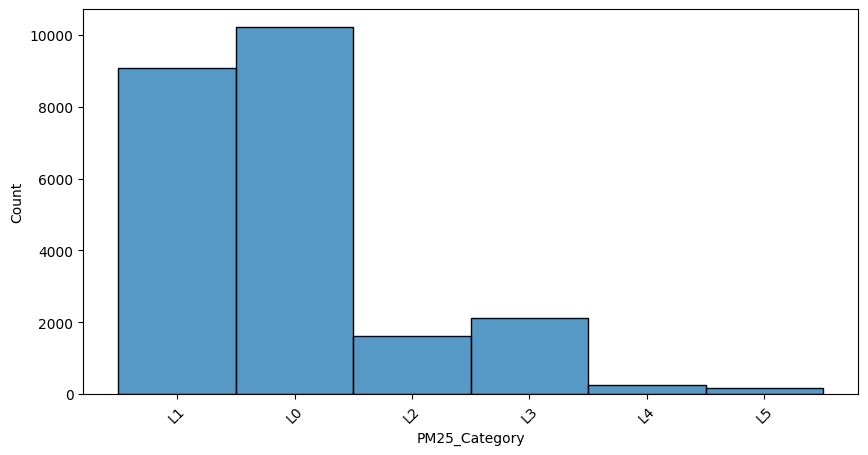

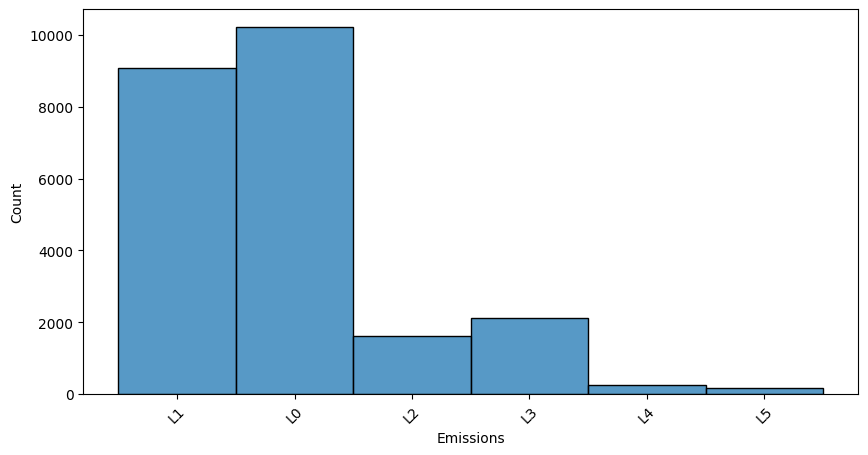

,Country,City,CO_Category,Ozone_Category,NO2_Category,PM25_Category,Emissions
count,23036,23462,21117,23463,23463,23463,23463
unique,175,23462,2,5,2,6,6
top,United States of America,Marang,Good,Good,Good,L0,L0
freq,2872,1,21115,21069,23448,10208,10208


In [9]:
show_categorical_info(cat_data, labels)

#### Atribute corellation


In [10]:
def compute_num_features_correlation(
    data: pd.DataFrame,
    threshold: float = 0.8,
    annot: bool = True,
    show_correlations: bool = False,
) -> list[str]:
    correlation = data.corr()
    correlated_features = set()

    sns.heatmap(correlation, annot=annot, fmt=".2f", cmap="coolwarm")
    plt.show()

    for i, row in enumerate(correlation.columns):
        for j, col in enumerate(correlation.columns):
            if i <= j or col in correlated_features:
                continue

            corr = correlation.loc[row, col]
            if abs(corr) < threshold:
                continue

            correlated_features.add(col)

            if not show_correlations:
                continue

            correlated_data = data[[row, col]].copy()
            correlated_data.sort_values(by=row, inplace=True)
            correlated_data.reset_index(drop=True, inplace=True)

            sns.lmplot(data=correlated_data, x=row, y=col, ci=None)
            plt.xlabel(row)
            plt.ylabel(col)
            plt.show()

    return list(correlated_features)

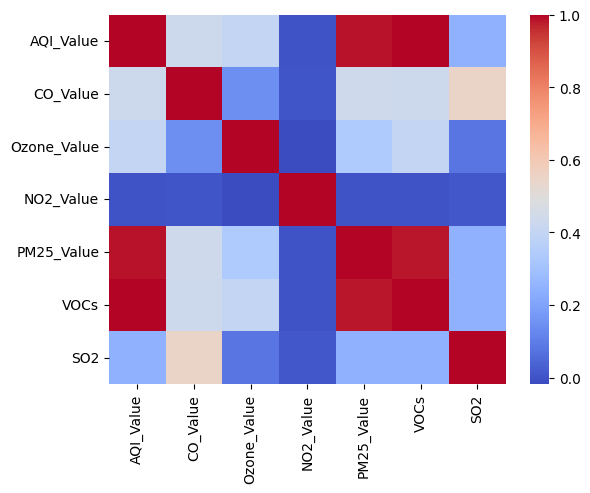

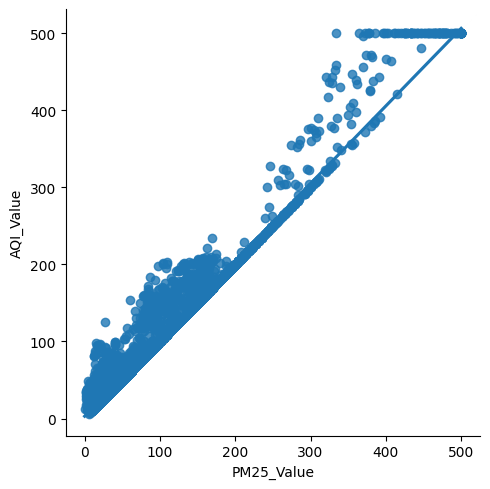

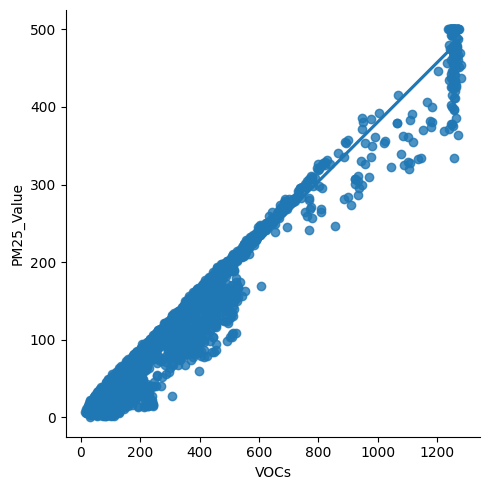

In [11]:
correlated_num_features = compute_num_features_correlation(
    num_data, show_correlations=True, annot=False, threshold=0.9
)

In [12]:
def compute_cat_features_correlation(
    data: pd.DataFrame,
    annot: bool = True,
    show_correlations: bool = False,
):
    pvalues = np.zeros((len(data.columns), len(data.columns)))

    for i, row in enumerate(data.columns):
        for j, col in enumerate(data.columns):
            if i == j:
                continue

            observed = pd.crosstab(data[row], data[col])
            statistic = sp.stats.chi2_contingency(observed)
            pvalue = statistic.pvalue
            pvalues[i, j] = pvalue

            if not show_correlations:
                continue

            sns.heatmap(observed, annot=annot, fmt="d", cbar=False, cmap="coolwarm")
            plt.show()

    sns.heatmap(pvalues, annot=annot, fmt=".2f", cmap="coolwarm")
    plt.xticks(
        ticks=0.5 + np.arange(len(data.columns)),
        labels=data.columns,
        rotation=90,
    )
    plt.yticks(
        ticks=0.5 + np.arange(len(data.columns)),
        labels=data.columns,
        rotation=0,
    )
    plt.show()

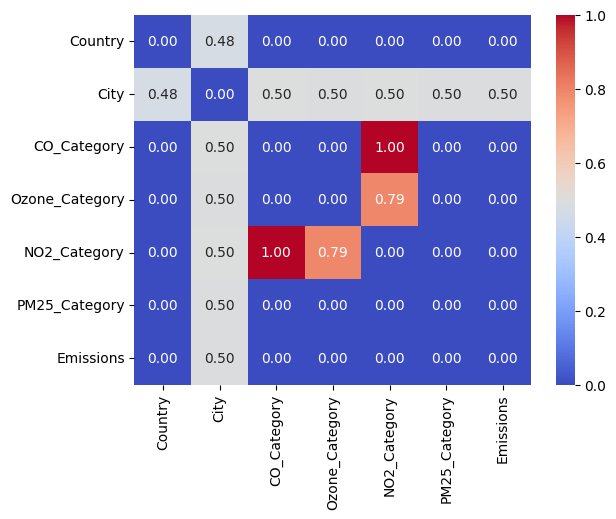

In [13]:
compute_cat_features_correlation(
    cat_data,
    show_correlations=False,
    annot=True,
)
correlated_cat_features = ["PM25_Category"]

### Preprocessing


#### Extreme values


In [14]:
class OutlierRemover:
    def __init__(self, q1: float = 0.25, q3: float = 0.75):
        self.q1 = q1
        self.q3 = q3

    def transform(self, X: pd.DataFrame) -> pd.DataFrame:
        for col in X.columns:
            values = X[col]

            q1 = values.quantile(self.q1)
            q3 = values.quantile(self.q3)
            iqr = q3 - q1
            lower_bound = q1 - 1.5 * iqr
            upper_bound = q3 + 1.5 * iqr

            X.loc[(values < lower_bound) | (values > upper_bound), col] = np.nan
        return X

#### Redundant attributes


In [15]:
redundant_features = ["City"]  # unique values, not useful
redundant_features += correlated_num_features
redundant_features += correlated_cat_features

numeric_columns = [x for x in numeric_columns if x not in redundant_features]
categorical_columns = [x for x in categorical_columns if x not in redundant_features]

### Preprocessing pipeline


In [16]:
numeric_pipeline = sk.pipeline.Pipeline(
    steps=[
        ("imputer", sk.impute.SimpleImputer()),
        ("scaler", sk.preprocessing.RobustScaler()),
    ]
)

categorical_pipeline = sk.pipeline.Pipeline(
    steps=[
        ("imputer", sk.impute.SimpleImputer(strategy="most_frequent")),
        (
            "encoder",
            sk.preprocessing.OneHotEncoder(
                handle_unknown="ignore", sparse_output=False
            ),
        ),
    ]
)

In [17]:
preprocessor = sk.compose.ColumnTransformer(
    transformers=[
        ("extra", "drop", redundant_features),
        ("numeric", numeric_pipeline, numeric_columns),
        ("categorical", categorical_pipeline, categorical_columns),
    ]
)

label_encoder = sk.preprocessing.LabelEncoder()

### Prediction


#### Loading and preprocessing data


In [18]:
train_data = pd.read_csv("datasets/air_pollution_train.csv")
test_data = pd.read_csv("datasets/air_pollution_test.csv")

In [19]:
train_labels = label_encoder.fit_transform(train_data[label_column])
train_data[numeric_columns] = OutlierRemover(q1=0.1, q3=0.9).transform(
    train_data[numeric_columns]
)
train_data = preprocessor.fit_transform(train_data)

test_labels = label_encoder.transform(test_data[label_column])
test_data = preprocessor.transform(test_data)

#### Classifiers


In [20]:
def run_classifier(
    name: str, classifier, test_data: pd.DataFrame, test_labels: pd.Series
) -> tuple[str, float, float, float, float]:
    predicted_labels = classifier.predict(test_data)

    conf_mat = sk.metrics.confusion_matrix(test_labels, predicted_labels)
    sns.heatmap(
        conf_mat,
        annot=True,
        fmt="d",
        cmap="coolwarm",
        cbar=False,
        xticklabels=label_encoder.classes_,
        yticklabels=label_encoder.classes_,
    )
    plt.xlabel("Predicted label")
    plt.ylabel("True label")
    plt.show()

    accuracy = classifier.score(test_data, test_labels)
    precison = sk.metrics.precision_score(
        test_labels, predicted_labels, average="macro", zero_division=0
    )
    recall = sk.metrics.recall_score(test_labels, predicted_labels, average="macro")
    f1 = sk.metrics.f1_score(test_labels, predicted_labels, average="macro")

    print(
        sk.metrics.classification_report(
            test_labels, predicted_labels, target_names=label_encoder.classes_
        )
    )
    return name, accuracy, precison, recall, f1

In [21]:
scores = []

##### Decision Tree


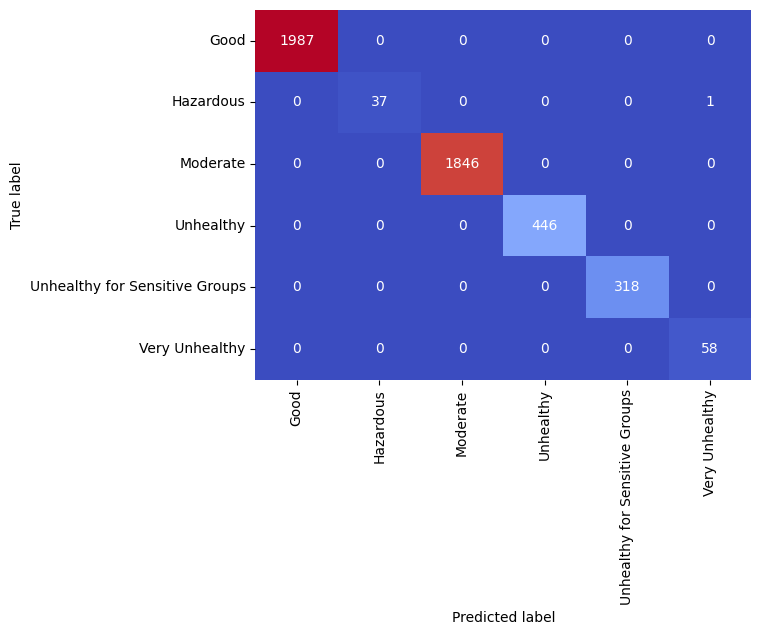

                                precision    recall  f1-score   support

                          Good       1.00      1.00      1.00      1987
                     Hazardous       1.00      0.97      0.99        38
                      Moderate       1.00      1.00      1.00      1846
                     Unhealthy       1.00      1.00      1.00       446
Unhealthy for Sensitive Groups       1.00      1.00      1.00       318
                Very Unhealthy       0.98      1.00      0.99        58

                      accuracy                           1.00      4693
                     macro avg       1.00      1.00      1.00      4693
                  weighted avg       1.00      1.00      1.00      4693



In [22]:
classifier = sk.tree.DecisionTreeClassifier()
classifier.fit(train_data, train_labels)

stats = run_classifier(
    "Decision Tree",
    classifier,
    test_data,
    test_labels,
)
scores.append(stats)

##### Random forest


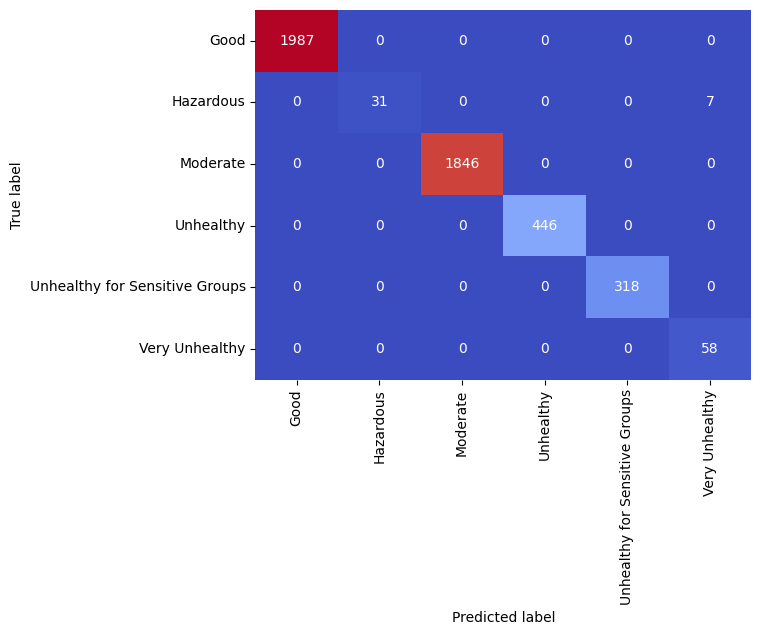

                                precision    recall  f1-score   support

                          Good       1.00      1.00      1.00      1987
                     Hazardous       1.00      0.82      0.90        38
                      Moderate       1.00      1.00      1.00      1846
                     Unhealthy       1.00      1.00      1.00       446
Unhealthy for Sensitive Groups       1.00      1.00      1.00       318
                Very Unhealthy       0.89      1.00      0.94        58

                      accuracy                           1.00      4693
                     macro avg       0.98      0.97      0.97      4693
                  weighted avg       1.00      1.00      1.00      4693



In [23]:
classifier = sk.ensemble.RandomForestClassifier()
classifier.fit(train_data, train_labels)

stats = run_classifier(
    "Random Forest",
    classifier,
    test_data,
    test_labels,
)
scores.append(stats)

##### Logistic regression


In [24]:
class MultiClassLogisticRegression:
    class LogisticRegression:
        @staticmethod
        def sigmoid(x: np.ndarray) -> np.ndarray:
            return 1 / (1 + np.exp(-x))

        def __init__(self, max_iter: int, lr: float):
            self.max_iter = max_iter
            self.lr = lr

        def predict(self, X: np.ndarray) -> np.ndarray:
            return self.sigmoid(X @ self.w)

        def fit(self, X: np.ndarray, t: np.ndarray):
            n, d = X.shape
            self.w = np.random.randn(d)
            self.bias = np.random.randn()

            for _ in range(self.max_iter):
                y = self.predict(X)
                error = y - t
                grad = (1 / n) * (X.T @ error)
                self.w -= self.lr * grad
                self.bias -= self.lr * (1 / n) * np.sum(error)

        def accuracy(self, X, t):
            y = self.predict(X)
            n, _ = y.shape

            return (np.sum(y[t == 1] >= 0.5) + np.sum(y[t == 0] < 0.5)) / n

    def __init__(self, max_iter: int = 1000, learning_rate: float = 0.01):
        self.max_iter = max_iter
        self.learning_rate = learning_rate

    def fit(self, X: np.ndarray, labels: np.ndarray):
        self.predictors = []

        for target in np.unique(labels):
            target_labels = labels == target

            predictor = self.LogisticRegression(self.max_iter, self.learning_rate)
            predictor.fit(X, target_labels)

            self.predictors.append(predictor)

    def predict(self, X: np.ndarray) -> np.ndarray:
        y = self.predictors[0].predict(X)
        classes = np.zeros_like(y, dtype=int)

        for i, predictor in enumerate(self.predictors[1:]):
            yy = predictor.predict(X)
            improv = yy > y

            y[improv] = yy[improv]
            classes[improv] = i + 1

        return classes

    def score(self, X: np.ndarray, labels: pd.Series) -> float:
        Y = self.predict(X)
        return sk.metrics.accuracy_score(labels, Y)

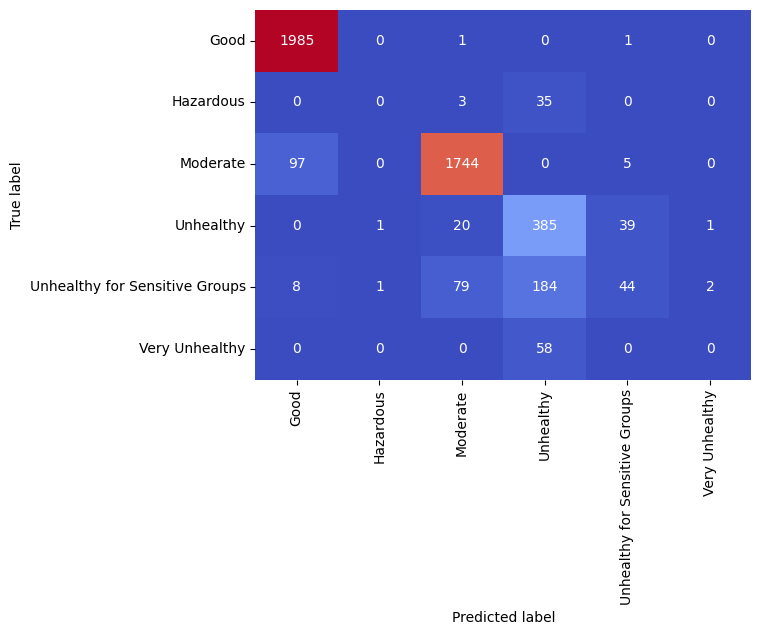

                                precision    recall  f1-score   support

                          Good       0.95      1.00      0.97      1987
                     Hazardous       0.00      0.00      0.00        38
                      Moderate       0.94      0.94      0.94      1846
                     Unhealthy       0.58      0.86      0.69       446
Unhealthy for Sensitive Groups       0.49      0.14      0.22       318
                Very Unhealthy       0.00      0.00      0.00        58

                      accuracy                           0.89      4693
                     macro avg       0.49      0.49      0.47      4693
                  weighted avg       0.86      0.89      0.86      4693



In [25]:
classifier = MultiClassLogisticRegression(max_iter=2000, learning_rate=0.01)
classifier.fit(train_data, train_labels)

stats = run_classifier(
    "Logistic Regression",
    classifier,
    test_data,
    test_labels,
)
scores.append(stats)

##### Multi-layered perceptron


In [29]:
def train_mlp(
    train_data: pd.DataFrame,
    train_labels: pd.Series,
    test_data: pd.DataFrame,
    test_labels: pd.Series,
    iters: int = 200,
    **args
) -> sk.neural_network.MLPClassifier:
    classifier = sk.neural_network.MLPClassifier(**args, warm_start=True)
    train_loss, test_loss = [], []
    train_acc, test_acc = [], []

    classifier.partial_fit(train_data, train_labels, classes=np.unique(train_labels))

    for _ in range(iters):
        classifier.partial_fit(train_data, train_labels)

        train_loss.append(
            sk.metrics.log_loss(
                train_labels,
                classifier.predict_proba(train_data),
                labels=classifier.classes_,
            )
        )
        test_loss.append(
            sk.metrics.log_loss(
                test_labels,
                classifier.predict_proba(test_data),
                labels=classifier.classes_,
            )
        )

        train_acc.append(
            sk.metrics.f1_score(
                train_labels, classifier.predict(train_data), average="macro"
            )
        )
        test_acc.append(
            sk.metrics.f1_score(
                test_labels, classifier.predict(test_data), average="macro"
            )
        )

    sns.lineplot(train_loss, label="Train Loss")
    sns.lineplot(test_loss, label="Test Loss")
    plt.xlabel("Iteration")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

    sns.lineplot(train_acc, label="Train F1 Score")
    sns.lineplot(test_acc, label="Test F1 Score")
    plt.xlabel("Iteration")
    plt.ylabel("F1 Score")
    plt.legend()
    plt.show()
    return classifier

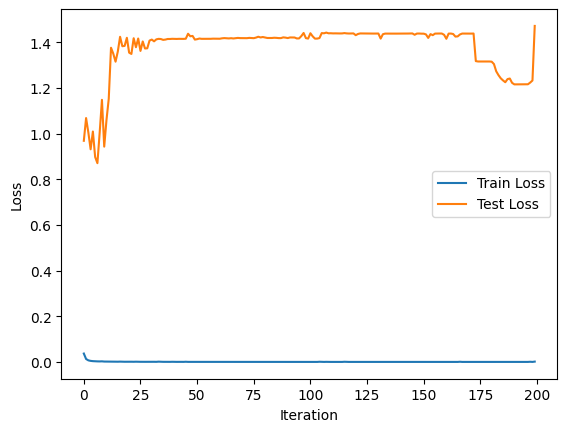

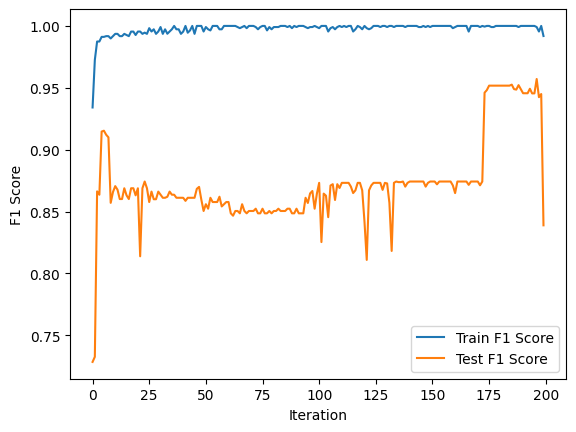

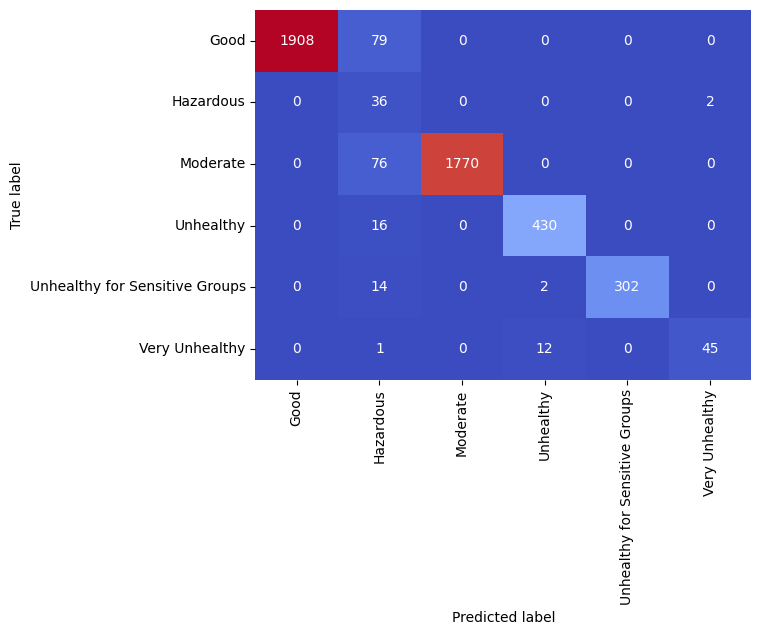

                                precision    recall  f1-score   support

                          Good       1.00      0.96      0.98      1987
                     Hazardous       0.16      0.95      0.28        38
                      Moderate       1.00      0.96      0.98      1846
                     Unhealthy       0.97      0.96      0.97       446
Unhealthy for Sensitive Groups       1.00      0.95      0.97       318
                Very Unhealthy       0.96      0.78      0.86        58

                      accuracy                           0.96      4693
                     macro avg       0.85      0.93      0.84      4693
                  weighted avg       0.99      0.96      0.97      4693



In [30]:
classifier = train_mlp(
    train_data,
    train_labels,
    test_data,
    test_labels,
    hidden_layer_sizes=(64, 64),
)

stats = run_classifier(
    "Neural Network",
    classifier,
    test_data,
    test_labels,
)
scores.append(stats)

#### Classifier comparison


In [ ]:
def compare_classifiers(scores: list[tuple[str, float, float, float, float]]):
    columns = ["Name", "Accuracy", "Precision", "Recall", "F1"]
    scores = pd.DataFrame(scores, columns=columns)

    for col in columns[1:]:
        sns.barplot(
            data=scores,
            x=columns[0],
            y=col,
        )

        plt.xlabel("Classifier")
        plt.ylabel(f"{col} score")
        plt.title(f"{col} score for different classifiers")
        plt.show()

In [ ]:
compare_classifiers(scores)

## News popularity


In [31]:
data = pd.read_csv("datasets/news_popularity_full.csv")

In [32]:
numeric_columns = [
    " days_since_published",
    " title_word_count",
    " content_word_count",
    " unique_word_ratio",
    " non_stop_word_ratio",
    " unique_non_stop_ratio",
    " external_links",
    " internal_links",
    " image_count",
    " video_count",
    " avg_word_length",
    " keyword_count",
    " keyword_worst_min_shares",
    " keyword_worst_max_shares",
    " keyword_worst_avg_shares",
    " keyword_best_min_shares",
    " keyword_best_max_shares",
    " keyword_best_avg_shares",
    " keyword_avg_min_shares",
    " keyword_avg_max_shares",
    " keyword_avg_avg_shares",
    " ref_min_shares",
    " ref_max_shares",
    " ref_avg_shares",
    " topic_0_relevance",
    " topic_1_relevance",
    " topic_2_relevance",
    " topic_3_relevance",
    " topic_4_relevance",
    " content_subjectivity",
    " content_sentiment",
    " positive_word_rate",
    " negative_word_rate",
    " non_neutral_positive_rate",
    " non_neutral_negative_rate",
    " avg_positive_sentiment",
    " min_positive_sentiment",
    " max_positive_sentiment",
    " avg_negative_sentiment",
    " min_negative_sentiment",
    " max_negative_sentiment",
    " title_subjectivity",
    " title_sentiment",
    " title_subjectivity_magnitude",
    " title_sentiment_magnitude",
    " engagement_ratio",
    " content_density",
]
categorical_columns = [
    "url",
    " channel_lifestyle",
    " channel_entertainment",
    " channel_business",
    " channel_social_media",
    " channel_tech",
    " channel_world",
    " day_monday",
    " day_tuesday",
    " day_wednesday",
    " day_thursday",
    " day_friday",
    " day_saturday",
    " day_sunday",
    " is_weekend",
    " publication_period",
]
label_column = "popularity_category"

In [33]:
num_data, cat_data, labels = split_data(
    data, numeric_columns, categorical_columns, label_column
)

### Exploratory data analysis


,days_since_published,title_word_count,content_word_count,unique_word_ratio,non_stop_word_ratio,unique_non_stop_ratio,external_links,internal_links,image_count,video_count,...,max_positive_sentiment,avg_negative_sentiment,min_negative_sentiment,max_negative_sentiment,title_subjectivity,title_sentiment,title_subjectivity_magnitude,title_sentiment_magnitude,engagement_ratio,content_density
count,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,...,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,35680.000000
mean,354.530471,10.398749,546.514731,0.548216,0.996469,0.689175,192.250110,3.293638,4.544143,1.249874,...,0.756728,-0.259524,-0.521944,-0.107500,0.282353,0.071425,0.341843,0.156064,1054.066316,1986.559830
std,214.163767,2.114037,471.107508,3.520708,5.231231,3.264816,905.415876,3.855141,8.309434,4.107855,...,0.247786,0.127726,0.290290,0.095373,0.324247,0.265450,0.188791,0.226294,3496.605663,2209.101848
min,8.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,-1.000000,-1.000000,-1.000000,0.000000,-1.000000,0.000000,0.000000,0.041667,32.759785
25%,164.000000,9.000000,246.000000,0.470870,1.000000,0.625739,4.000000,1.000000,1.000000,0.000000,...,0.600000,-0.328383,-0.700000,-0.125000,0.000000,0.000000,0.166667,0.000000,220.000000,746.069031
50%,339.000000,10.000000,409.000000,0.539226,1.000000,0.690476,8.000000,3.000000,1.000000,0.000000,...,0.800000,-0.253333,-0.500000,-0.100000,0.150000,0.000000,0.500000,0.000000,465.500000,1314.549818
75%,542.000000,12.000000,716.000000,0.608696,1.000000,0.754630,15.000000,4.000000,4.000000,1.000000,...,1.000000,-0.186905,-0.300000,-0.050000,0.500000,0.150000,0.500000,0.250000,900.000000,2506.707506
max,731.000000,23.000000,8474.000000,701.000000,1042.000000,650.000000,6078.616775,116.000000,128.000000,91.000000,...,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.500000,1.000000,221200.000000,58857.969230


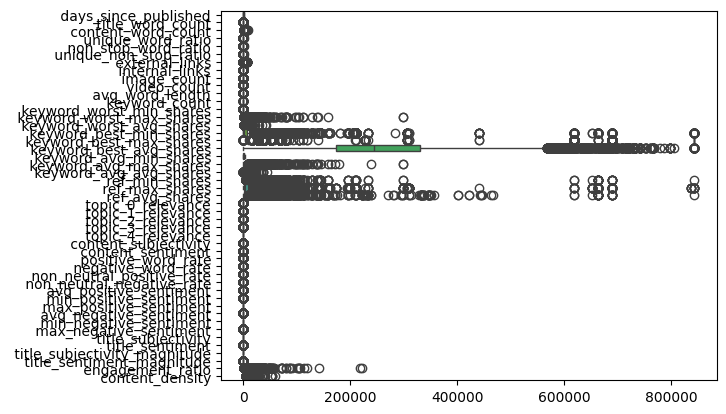

In [34]:
show_numerical_info(num_data)

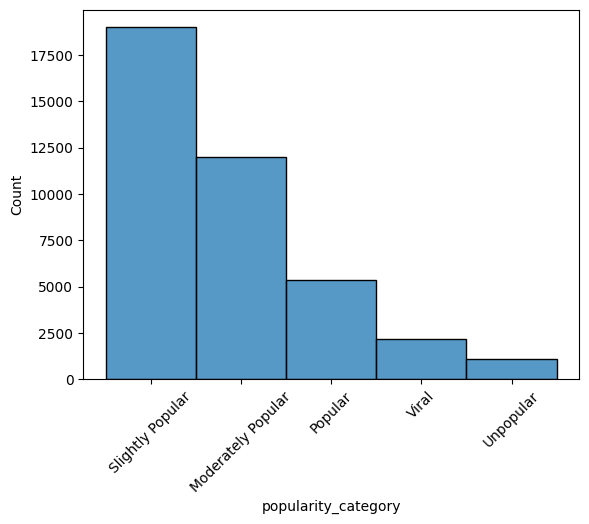

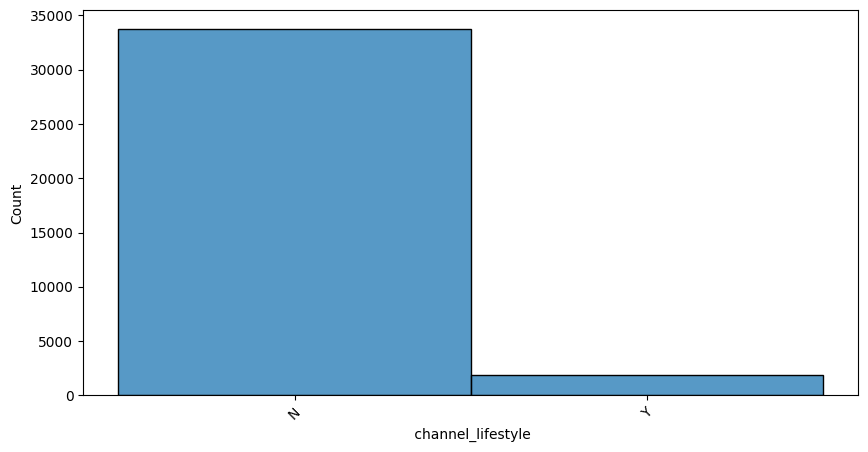

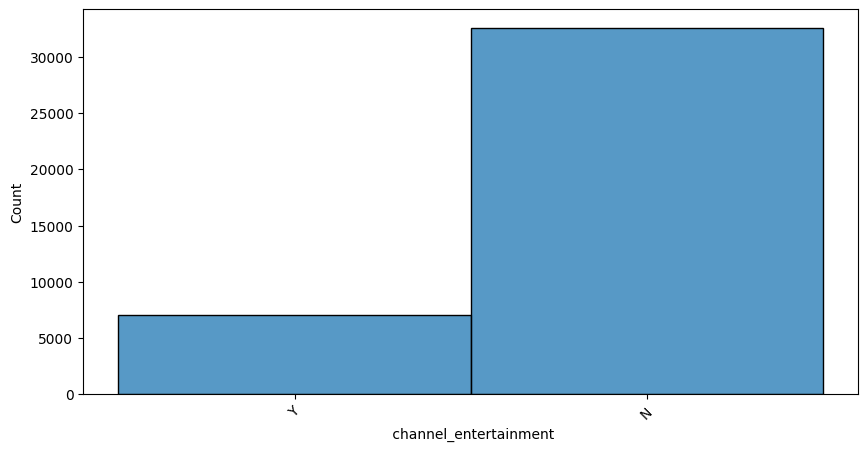

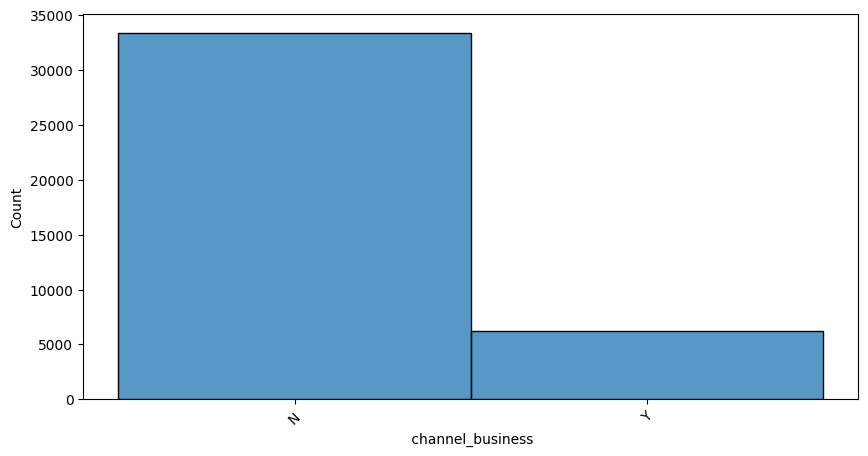

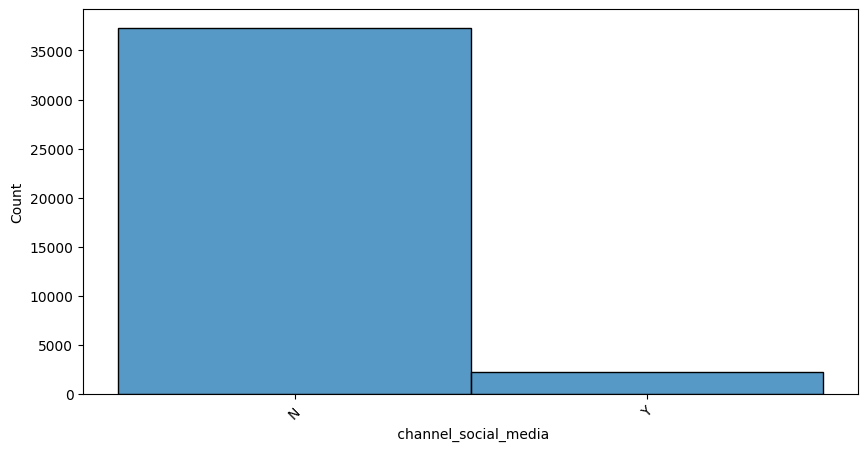

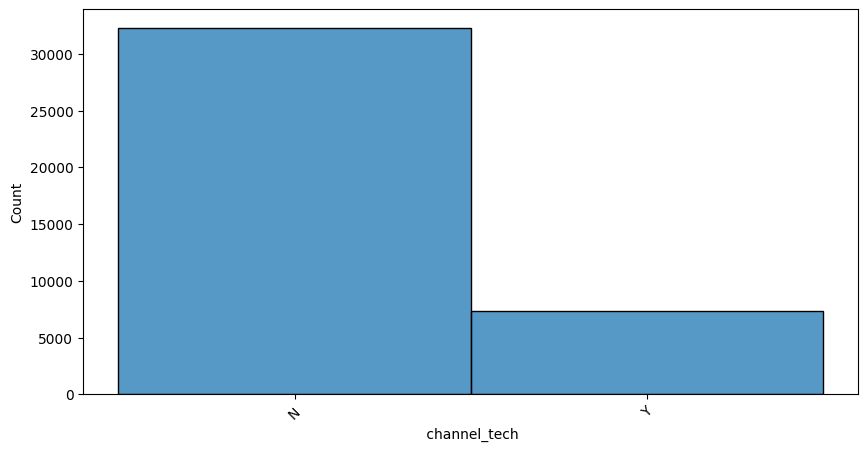

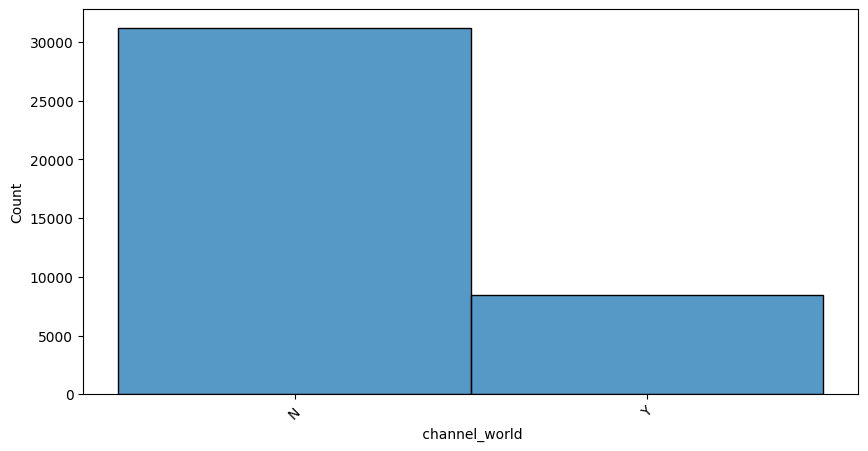

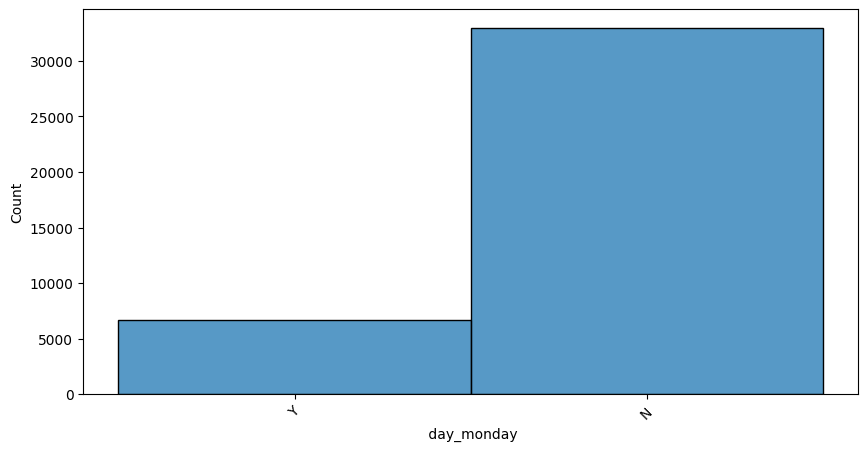

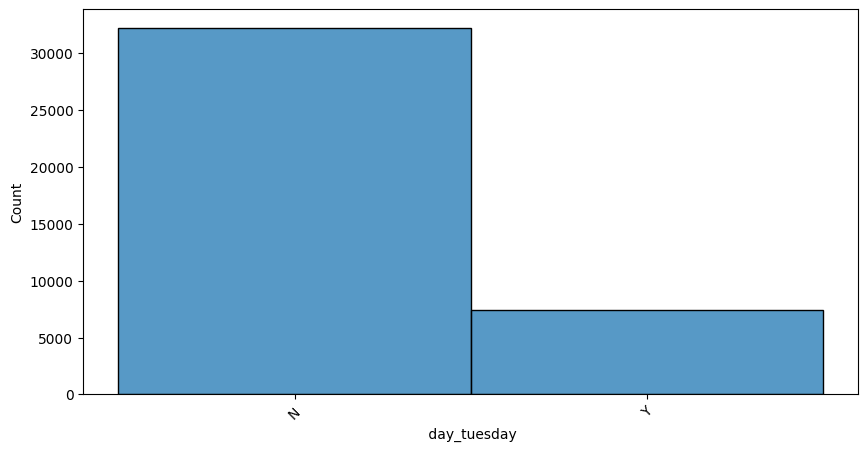

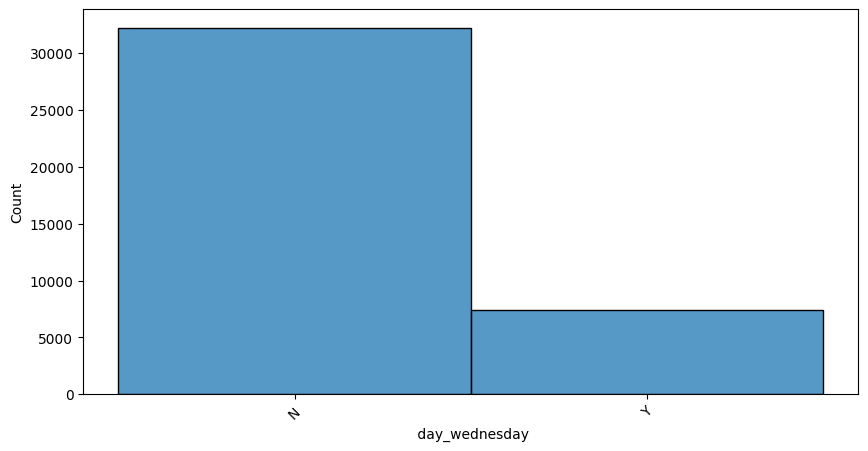

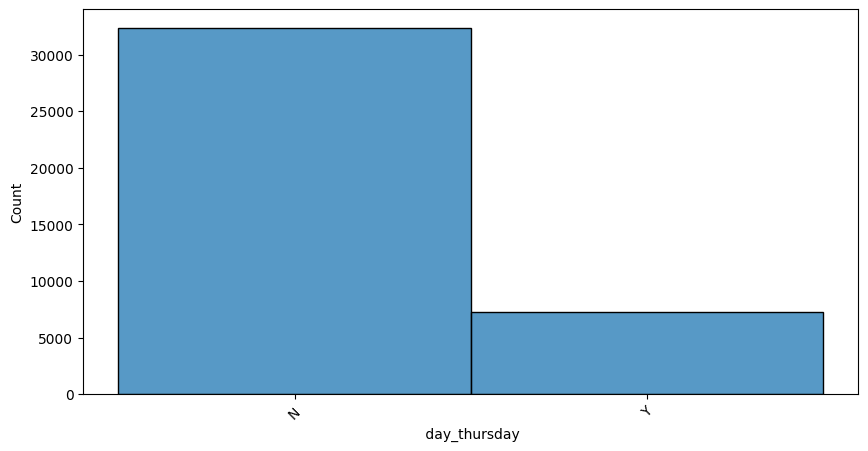

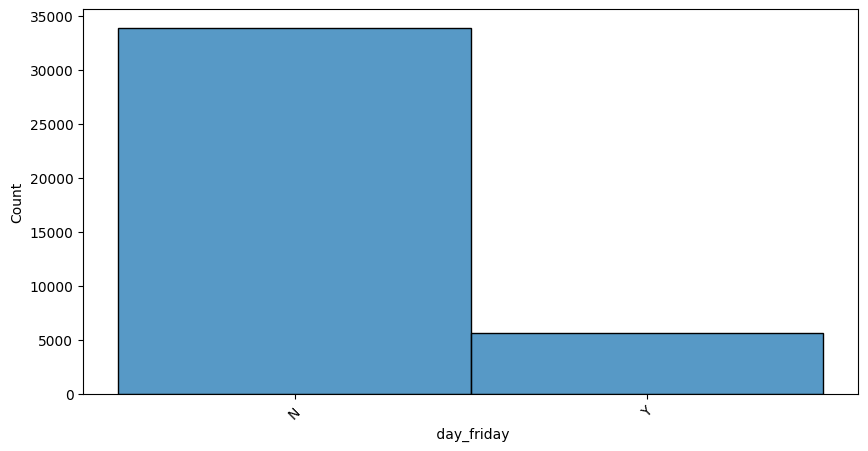

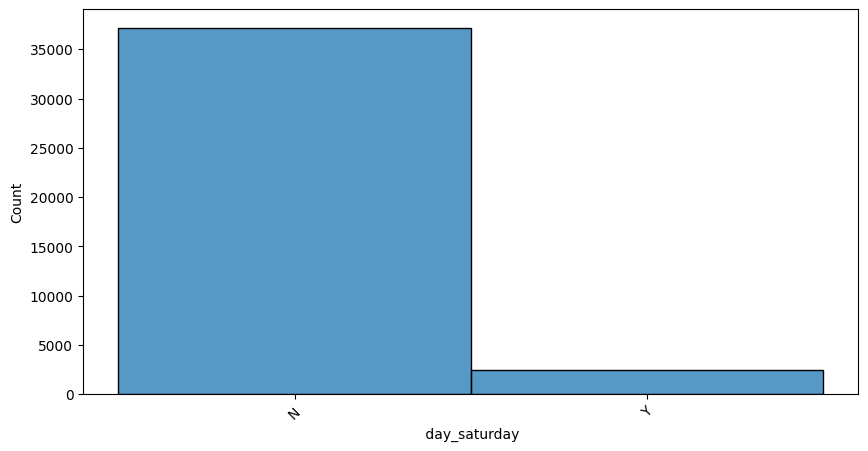

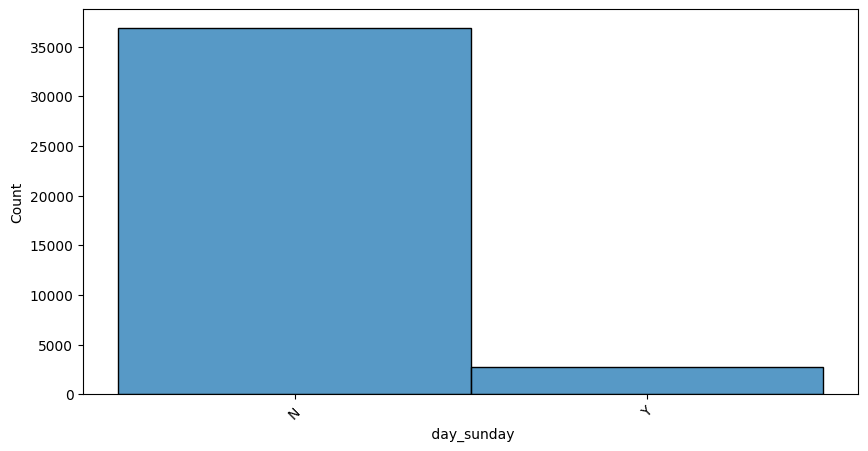

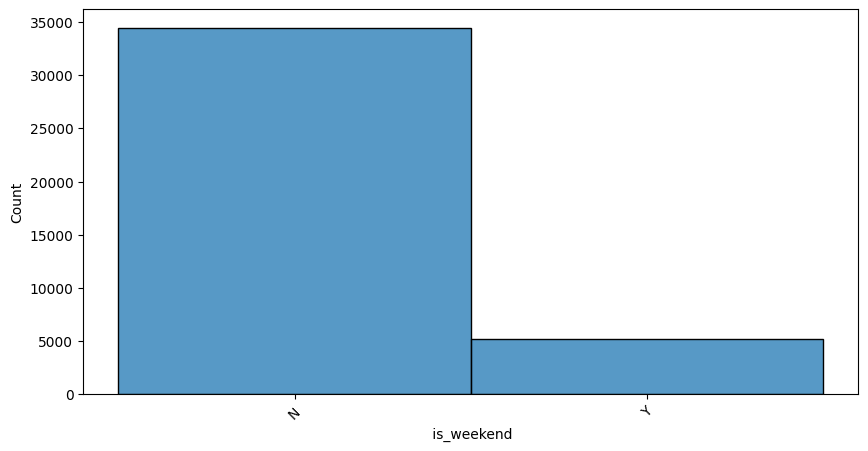

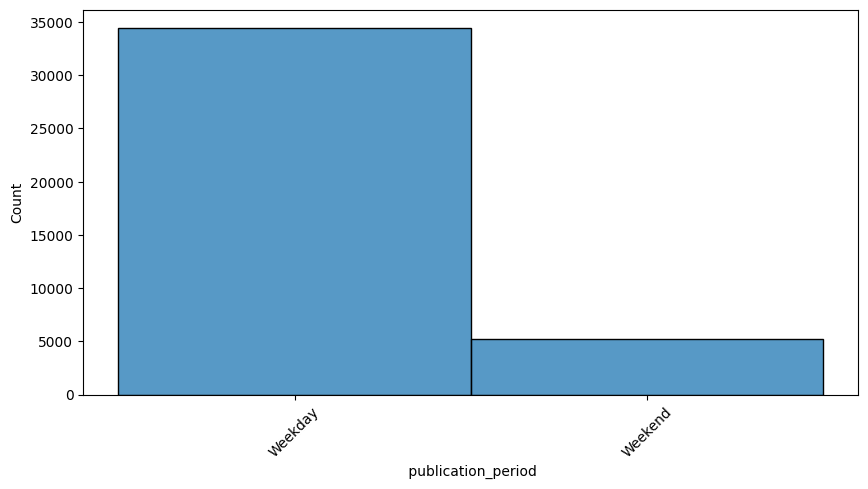

,url,channel_lifestyle,channel_entertainment,channel_business,channel_social_media,channel_tech,channel_world,day_monday,day_tuesday,day_wednesday,day_thursday,day_friday,day_saturday,day_sunday,is_weekend,publication_period
count,39644,35680,39644,39644,39644,39644,39644,39644,39644,39644,39644,39644,39644,39644,39644,39644
unique,39644,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2
top,http://mashable.com/2014/12/27/youtube-channel...,N,N,N,N,N,N,N,N,N,N,N,N,N,N,Weekday
freq,1,33777,32587,33386,37321,32298,31217,32983,32254,32209,32377,33943,37191,36907,34454,34454


In [35]:
show_categorical_info(cat_data, labels)

#### Atribute corellation


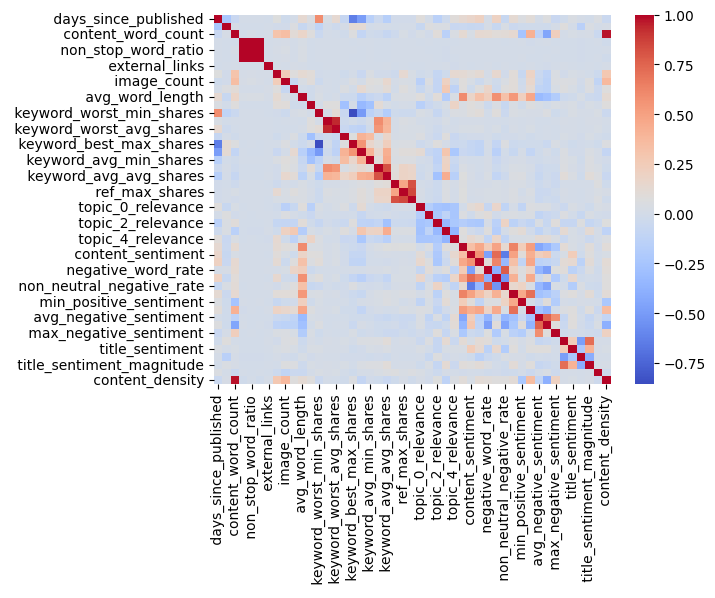

In [36]:
compute_num_features_correlation(num_data, annot=False)
correlated_num_features = [" keyword_worst_avg_shares", " content_word_count"]

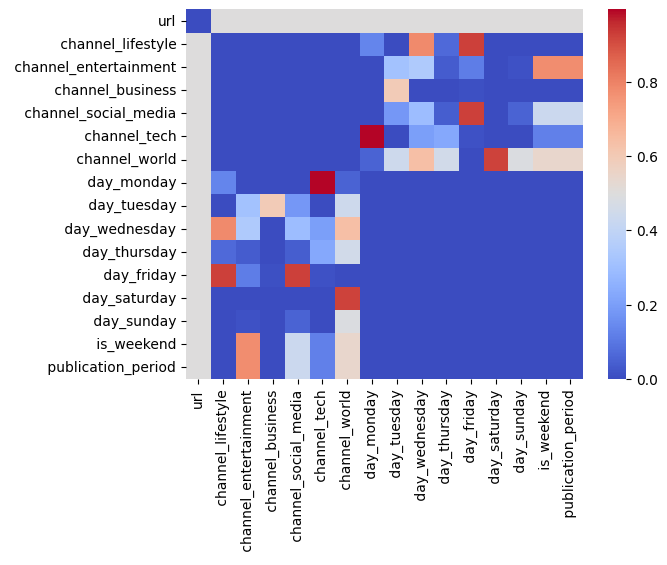

In [37]:
compute_cat_features_correlation(cat_data, annot=False)
correlated_cat_features = [" is_weekend"]

### Preprocessing


In [38]:
redundant_features = ["url"]  # unique values, not useful
redundant_features += correlated_num_features
redundant_features += correlated_cat_features

numeric_columns = [x for x in numeric_columns if x not in redundant_features]
categorical_columns = [x for x in categorical_columns if x not in redundant_features]

In [39]:
numeric_pipeline = sk.pipeline.Pipeline(
    steps=[
        ("imputer", sk.impute.SimpleImputer()),
        ("scaler", sk.preprocessing.StandardScaler()),
    ]
)

categorical_pipeline = sk.pipeline.Pipeline(
    steps=[
        ("imputer", sk.impute.SimpleImputer(strategy="most_frequent")),
        (
            "encoder",
            sk.preprocessing.OrdinalEncoder(
                handle_unknown="use_encoded_value", unknown_value=-1
            ),
        ),
    ]
)

In [40]:
preprocessor = sk.compose.ColumnTransformer(
    transformers=[
        ("extra", "drop", redundant_features),
        ("numeric", numeric_pipeline, numeric_columns),
        ("categorical", categorical_pipeline, categorical_columns),
    ]
)

label_encoder = sk.preprocessing.LabelEncoder()

#### Loading and preprocessing data


In [41]:
train_data = pd.read_csv("datasets/news_popularity_train.csv")
test_data = pd.read_csv("datasets/news_popularity_test.csv")

/tmp/ipykernel_69183/3985220423.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.loc[(values < lower_bound) | (values > upper_bound), col] = np.nan
/tmp/ipykernel_69183/3985220423.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.loc[(values < lower_bound) | (values > upper_bound), col] = np.nan
/tmp/ipykernel_69183/3985220423.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.loc[(values < lower_bound) | (values > upper

,numeric__ days_since_published,numeric__ title_word_count,numeric__ unique_word_ratio,numeric__ non_stop_word_ratio,numeric__ unique_non_stop_ratio,numeric__ external_links,numeric__ internal_links,numeric__ image_count,numeric__ video_count,numeric__ avg_word_length,...,categorical__ channel_tech,categorical__ channel_world,categorical__ day_monday,categorical__ day_tuesday,categorical__ day_wednesday,categorical__ day_thursday,categorical__ day_friday,categorical__ day_saturday,categorical__ day_sunday,categorical__ publication_period
count,3.171500e+04,3.171500e+04,3.171500e+04,3.171500e+04,3.171500e+04,3.171500e+04,3.171500e+04,3.171500e+04,3.171500e+04,3.171500e+04,...,31715.000000,31715.000000,31715.000000,31715.000000,31715.000000,31715.000000,31715.000000,31715.000000,31715.000000,31715.000000
mean,7.527743e-17,3.683217e-16,-7.366434e-16,7.507723e-09,3.203771e-16,2.251602e-16,4.086489e-16,-6.519563e-17,-3.517427e-17,6.949720e-16,...,0.183636,0.214473,0.167586,0.184613,0.188617,0.183320,0.144411,0.061548,0.069904,0.131452
std,1.000016e+00,1.000016e+00,1.000016e+00,1.000016e+00,1.000016e+00,1.000016e+00,1.000016e+00,1.000016e+00,1.000016e+00,1.000016e+00,...,0.387193,0.410462,0.373504,0.387989,0.391211,0.386935,0.351512,0.240337,0.254989,0.337899
min,-1.620731e+00,-3.970783e+00,-4.294149e+00,-4.301348e+00,-4.279462e+00,-1.216389e+00,-1.271203e+00,-6.662077e-01,-6.618102e-01,-3.979553e+00,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,-8.917619e-01,-6.614294e-01,-6.694238e-01,-4.060875e-01,-6.100672e-01,-7.333797e-01,-8.226318e-01,-4.826635e-01,-6.618102e-01,-6.711371e-01,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,-7.400854e-02,-1.886647e-01,0.000000e+00,2.241090e-01,0.000000e+00,-2.503707e-01,3.984109e-16,-4.826635e-01,-6.618102e-01,-2.542638e-03,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,8.745853e-01,7.568649e-01,6.148656e-01,7.380881e-01,6.247417e-01,3.533906e-01,5.230805e-01,-8.151002e-17,1.077973e+00,6.149557e-01,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.757759e+00,4.538983e+00,4.107189e+00,1.386892e+00,3.165499e+00,4.821224e+00,3.663076e+00,4.289487e+00,2.817755e+00,4.212754e+00,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


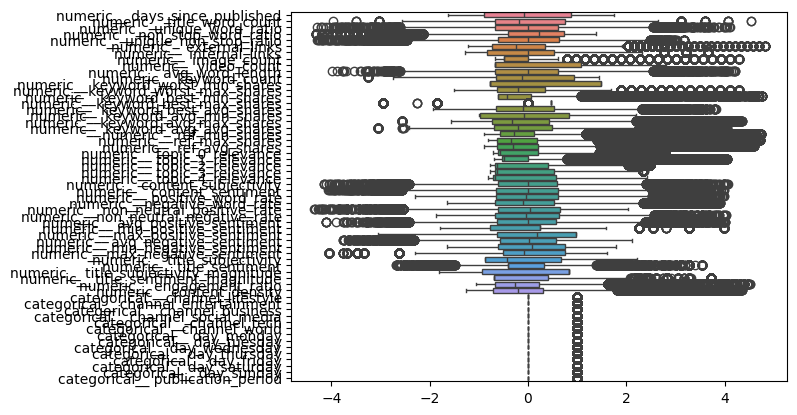

In [42]:
train_labels = label_encoder.fit_transform(train_data[label_column])
train_data[numeric_columns] = OutlierRemover(q1=0.15, q3=0.85).transform(
    train_data[numeric_columns]
)
train_data = preprocessor.fit_transform(train_data)

show_numerical_info(
    pd.DataFrame(train_data, columns=preprocessor.get_feature_names_out())
)

test_labels = label_encoder.transform(test_data[label_column])
test_data = preprocessor.transform(test_data)

### Training and prediction


In [43]:
scores = []

#### Decision Tree


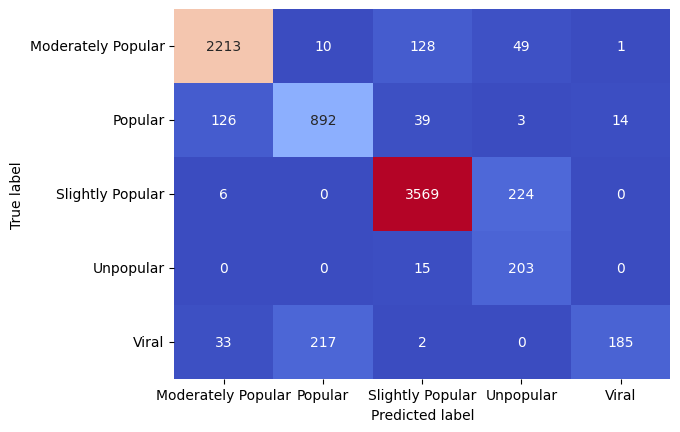

                    precision    recall  f1-score   support

Moderately Popular       0.93      0.92      0.93      2401
           Popular       0.80      0.83      0.81      1074
  Slightly Popular       0.95      0.94      0.95      3799
         Unpopular       0.42      0.93      0.58       218
             Viral       0.93      0.42      0.58       437

          accuracy                           0.89      7929
         macro avg       0.81      0.81      0.77      7929
      weighted avg       0.91      0.89      0.89      7929



In [44]:
classifier = sk.tree.DecisionTreeClassifier(
    min_samples_split=5,
    min_samples_leaf=5,
    criterion="entropy",
)
classifier.fit(train_data, train_labels)

stats = run_classifier(
    "Decision Tree",
    classifier,
    test_data,
    test_labels,
)
scores.append(stats)

#### Random forest


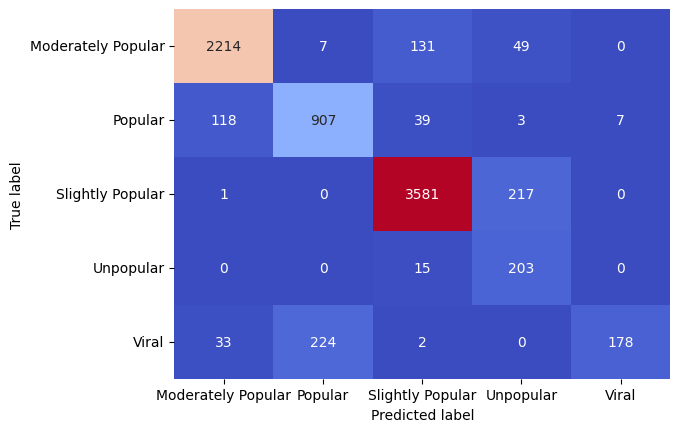

                    precision    recall  f1-score   support

Moderately Popular       0.94      0.92      0.93      2401
           Popular       0.80      0.84      0.82      1074
  Slightly Popular       0.95      0.94      0.95      3799
         Unpopular       0.43      0.93      0.59       218
             Viral       0.96      0.41      0.57       437

          accuracy                           0.89      7929
         macro avg       0.82      0.81      0.77      7929
      weighted avg       0.91      0.89      0.89      7929



In [45]:
classifier = sk.ensemble.RandomForestClassifier(
    n_estimators=500,
    min_samples_split=5,
    min_samples_leaf=5,
    criterion="entropy",
    max_features=1.0,
    n_jobs=-1,
)
classifier.fit(train_data, train_labels)

stats = run_classifier(
    "Random Forest",
    classifier,
    test_data,
    test_labels,
)
scores.append(stats)

#### Logistic regression


/tmp/ipykernel_69183/1301993371.py:5: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))


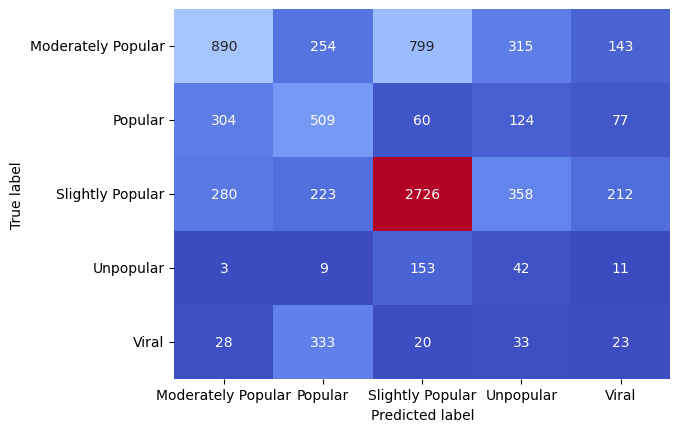

                    precision    recall  f1-score   support

Moderately Popular       0.59      0.37      0.46      2401
           Popular       0.38      0.47      0.42      1074
  Slightly Popular       0.73      0.72      0.72      3799
         Unpopular       0.05      0.19      0.08       218
             Viral       0.05      0.05      0.05       437

          accuracy                           0.53      7929
         macro avg       0.36      0.36      0.35      7929
      weighted avg       0.58      0.53      0.55      7929



/tmp/ipykernel_69183/1301993371.py:5: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))


In [49]:
classifier = MultiClassLogisticRegression(max_iter=10000, learning_rate=0.01)
classifier.fit(train_data, train_labels)

stats = run_classifier(
    "Logistic Regression",
    classifier,
    test_data,
    test_labels,
)
scores.append(stats)

#### Multi-layered perceptron


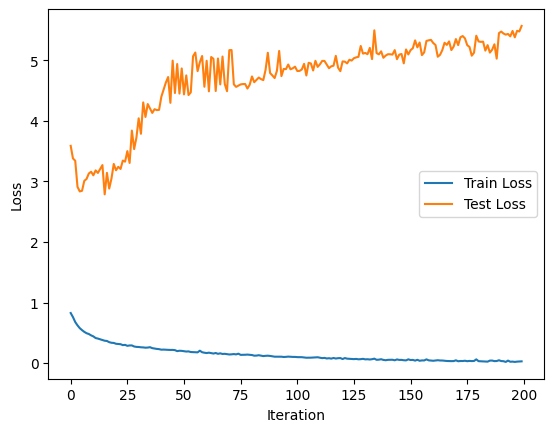

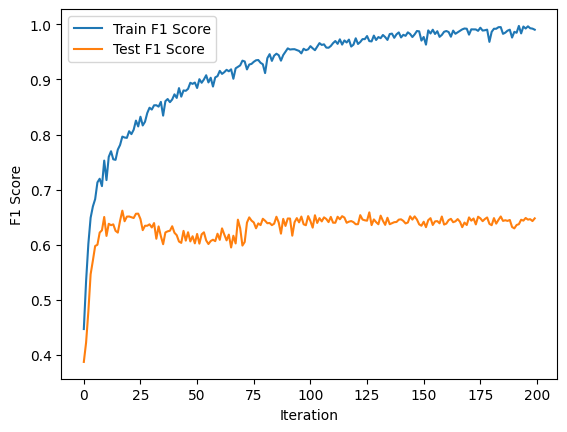

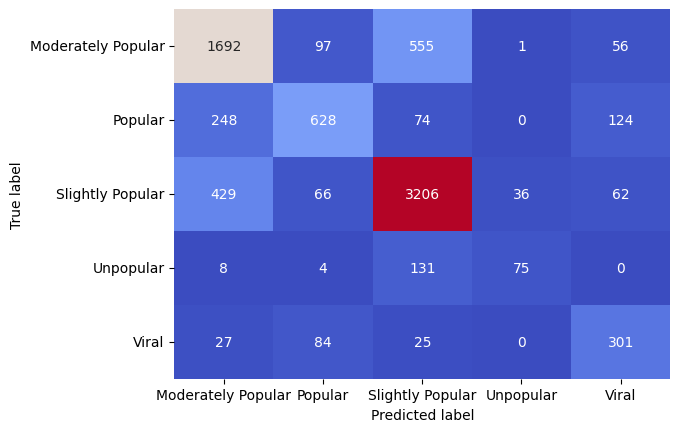

                    precision    recall  f1-score   support

Moderately Popular       0.70      0.70      0.70      2401
           Popular       0.71      0.58      0.64      1074
  Slightly Popular       0.80      0.84      0.82      3799
         Unpopular       0.67      0.34      0.45       218
             Viral       0.55      0.69      0.61       437

          accuracy                           0.74      7929
         macro avg       0.69      0.63      0.65      7929
      weighted avg       0.74      0.74      0.74      7929



In [48]:
classifier = train_mlp(
    train_data,
    train_labels,
    test_data,
    test_labels,
    iters=200,
    hidden_layer_sizes=[100, 100],
    activation="relu",
    solver="adam",
    learning_rate_init=0.001,
)

stats = run_classifier(
    "Neural Network",
    classifier,
    test_data,
    test_labels,
)
scores.append(stats)

#### Classifier comparison


In [ ]:
compare_classifiers(scores)